# Hyperparameter Tuning using SageMaker PyTorch Container

Kernel `conda_pytorch_p39` works well with this notebook.

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Host](#Host)

---

## Background

MNIST is a widely used dataset for handwritten digit classification. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). This tutorial will show how to train and test an MNIST model on SageMaker using PyTorch. It also shows how to use SageMaker Automatic Model Tuning to select appropriate hyperparameters in order to get the best model. 

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

---

## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).


In [1]:
import sagemaker
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-pytorch-mnist'

role = sagemaker.get_execution_role()

## Data
### Getting the data

Download the built-in MNIST dataset from the torchvision library. We also apply the following transformations -
- convert the input data into `torch.FloatTensor` and scale the pixel values to the range: `[0.0, 1.0]`.
- normalize the dataset using the mean and standard deviation of the pixel values from the dataset.

In [2]:
from torchvision import datasets, transforms

datasets.MNIST('data', download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Uploading the data to S3
We are going to use the `sagemaker.Session.upload_data` function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.


In [3]:
inputs = sagemaker_session.upload_data(path='data', bucket=bucket, key_prefix=prefix)
print('input spec (in this case, just an S3 path): {}'.format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-841336972682/sagemaker/DEMO-pytorch-mnist


## Train
### Training script
The `mnist.py` script provides all the code we need for training and hosting a SageMaker model (`model_fn` function to load a model).
The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* `SM_MODEL_DIR`: A string representing the path to the directory to write model artifacts to.
  These artifacts are uploaded to S3 for model hosting.
* `SM_NUM_GPUS`: The number of gpus available in the current container.
* `SM_CURRENT_HOST`: The name of the current container on the container network.
* `SM_HOSTS`: JSON encoded list containing all the hosts .

Supposing one input channel, 'training', was used in the call to the `fit()` method, the following will be set, following the format `SM_CHANNEL_[channel_name]`:

* `SM_CHANNEL_TRAINING`: A string representing the path to the directory containing data in the 'training' channel.

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to `model_dir` so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an `argparse.ArgumentParser` instance.

Because the SageMaker imports the training script, you should put your training code in a main guard (``if __name__=='__main__':``) if you are using the same script to host your model as we do in this example, so that SageMaker does not inadvertently run your training code at the wrong point in execution.

For example, the script run by this notebook:

In [4]:
!pygmentize mnist.py

import argparse
import json
import logging
import os
import sys
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))


# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1

### Set up hyperparameter tuning job
*Note, with the default setting below, the hyperparameter tuning job can take about 20 minutes to complete.*

Now that we have prepared the dataset and the script, we are ready to train models. Before we do that, one thing to note is there are many hyperparameters that can dramtically affect the performance of the trained models. For example, learning rate, batch size, number of epochs, etc. Since which hyperparameter setting can lead to the best result depends on the dataset as well, it is almost impossible to pick the best hyperparameter setting without searching for it. Using SageMaker Automatic Model Tuning, we can create a hyperparameter tuning job to search for the best hyperparameter setting in an automated and effective way.

In this example, we are using SageMaker Python SDK to set up and manage a hyperparameter tuning job. Specifically, we specify a range, or a list of possible values in the case of categorical hyperparameters, for each of the hyperparameter that we plan to tune. The hyperparameter tuning job will automatically launch multiple training jobs with different hyperparameter settings, evaluate results of those training jobs based on a predefined "objective metric", and select the hyperparameter settings for future attempts based on previous results. For each hyperparameter tuning job, we will give it a budget (max number of training jobs) and it will complete once that many training jobs have been executed.

Now we will set up the hyperparameter tuning job using SageMaker Python SDK, following below steps:
* Create an estimator to set up the PyTorch training job
* Define the ranges of hyperparameters we plan to tune, in this example, we are tuning learning_rate and batch size
* Define the objective metric for the tuning job to optimize
* Create a hyperparameter tuner with above setting, as well as tuning resource configurations 

Similar to training a single PyTorch job in SageMaker, we define our PyTorch estimator passing in the PyTorch script, IAM role, and (per job) hardware configuration. 

In [5]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="mnist.py",
                    role=role,
                    framework_version='1.13.1',
                    py_version='py39',
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    hyperparameters={
                        'epochs': 6,
                        'backend': 'gloo'
                    })

Once we've defined our estimator we can specify the hyperparameters we'd like to tune and their possible values.  We have three different types of hyperparameters.
- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

*Note, if possible, it's almost always best to specify a value as the least restrictive type.  For example, tuning learning rate as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with values 0.01, 0.1, 0.15, or 0.2. We did specify batch size as categorical parameter here since it is generally recommended to be the power of 2.*

In [6]:
hyperparameter_ranges = {'lr': ContinuousParameter(0.001, 0.1),'batch-size': CategoricalParameter([32,64,128,256,512])}

Next we'll specify the objective metric that we'd like to tune and its definition, which includes the regular expression (Regex) needed to extract that metric from the CloudWatch logs of the training job. In this particular case, our script emits average loss value and we will use it as the objective metric, we also set the objective_type to be 'minimize', so that hyperparameter tuning seeks to minize the objective metric when searching for the best hyperparameter setting. By default, objective_type is set to 'maximize'.

In [7]:
objective_metric_name = 'average test loss'
objective_type = 'Minimize'
metric_definitions = [{'Name': 'average test loss',
                       'Regex': 'Test set: Average loss: ([0-9\\.]+)'}]

Now, we'll create a `HyperparameterTuner` object, to which we pass:
- The PyTorch estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Tuning resource configurations such as Number of training jobs to run in total and how many training jobs can be run in parallel.

In [8]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=6,
                            max_parallel_jobs=3,
                            objective_type=objective_type)

### Launch hyperparameter tuning job
And finally, we can start our hyperprameter tuning job by calling `.fit()` and passing in the S3 path to our train and test dataset.

After the hyperprameter tuning job is created, you should be able to describe the tuning job to see its progress in the next step, and you can go to SageMaker console->Jobs to check out the progress of the progress of the hyperparameter tuning job.

In [9]:
tuner.fit({'training': inputs})
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..........................................................................................................................................!
!


## Host
### Create endpoint
After training, we use the tuner object to build and deploy a `PyTorchPredictor`. This creates a Sagemaker Endpoint -- a hosted prediction service that we can use to perform inference, based on the best model in the tuner. Remember in previous steps, the tuner launched multiple training jobs during tuning and the resulting model with the best objective metric is defined as the best model. 

As mentioned above we have implementation of `model_fn` in the `mnist.py` script that is required. We are going to use default implementations of `input_fn`, `predict_fn`, `output_fn` and `transform_fm` defined in [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers).

The arguments to the deploy function allow us to set the number and type of instances that will be used for the Endpoint. These do not need to be the same as the values we used for the training job. For example, you can train a model on a set of GPU-based instances, and then deploy the Endpoint to a fleet of CPU-based instances, but you need to make sure that you return or save your model as a cpu model similar to what we did in `mnist.py`. Here we will deploy the model to a single ```ml.m4.xlarge``` instance.

In [10]:
predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


2023-03-23 10:23:04 Starting - Found matching resource for reuse
2023-03-23 10:23:04 Downloading - Downloading input data
2023-03-23 10:23:04 Training - Training image download completed. Training in progress.
2023-03-23 10:23:04 Uploading - Uploading generated training model
2023-03-23 10:23:04 Completed - Resource retained for reuse
-------!

### Evaluate
We can now use this predictor to classify hand-written digits. 

We'll download the test data from the built-in dataset from torchvision and use a couple of images for testing the model.

Note that we apply the same transformations to the dataset and convert the tensor to numpy arrays.

In [11]:
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]))

from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
test_dataset_array = next(iter(test_loader))[0].numpy()

Choose an image for passing to the predictor and obtaining a prediction. Change the value of `idx` to pick a different image for testing.

In [12]:
idx = 1
test_image = test_dataset_array[idx]

Visualize the image. 

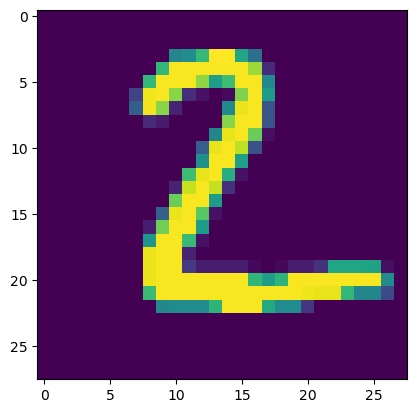

In [13]:
from matplotlib import pyplot as plt
plt.imshow(test_image.reshape(28, 28), interpolation='nearest')
plt.show()

Pass the chosen image to the predictor to obtain the prediction.

In [14]:
response = predictor.predict(test_image)
prediction = response.argmax(axis=1)[0]
print(prediction)

2


### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it

In [15]:
predictor.delete_endpoint()